In [28]:
from nemo.collections.tts.models import T5TTS_Model
from nemo.collections.tts.data.text_to_speech_dataset import T5TTSDataset, DatasetSample
from omegaconf.omegaconf import OmegaConf, open_dict
import torch
import os
import soundfile as sf
from IPython.display import display, Audio
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Checkpoint Paths

In [29]:
# Checkpoint and Hparams Paths
# hparams_file = "/datap/misc/icml2025_base_checkpoints/RoyCheckpoints/CML_WithRivaSpanish_NoPolishPortugese_SeparateCharTokenizer_hparams.yaml"
# checkpoint_file = "/datap/misc/icml2025_base_checkpoints/RoyCheckpoints/SeparateCharTokenizer_epoch12_fp32_DPO_3epochs_AllLanguages_0.05_ng1_epoch3.ckpt"

hparams_file = "/datap/misc/ChallengingFinetuneLocalTraining/Try2/T5TTS/0/hparams.yaml"
checkpoint_file = "/datap/misc/ChallengingFinetuneLocalTraining/epochlasthalf.ckpt"
# checkpoint_file = "/datap/misc/icml2025_base_checkpoints/decodercontext_small_sp_ks3CorrectWithPrior_onlyphoneme_epoch161.ckpt"

codecmodel_path = "/datap/misc/checkpoints/AudioCodec_21Hz_no_eliz.nemo"

# Temp out dir for saving audios
out_dir = "/datap/misc/t5tts_inference_notebook_samples"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Load Model

In [30]:
model_cfg = OmegaConf.load(hparams_file).cfg

with open_dict(model_cfg):
    model_cfg.codecmodel_path = codecmodel_path
    if hasattr(model_cfg, 'text_tokenizer'):
        # Backward compatibility for models trained with absolute paths in text_tokenizer
        model_cfg.text_tokenizer.g2p.phoneme_dict = "scripts/tts_dataset_files/ipa_cmudict-0.7b_nv23.01.txt"
        model_cfg.text_tokenizer.g2p.heteronyms = "scripts/tts_dataset_files/heteronyms-052722"
        model_cfg.text_tokenizer.g2p.phoneme_probability = 1.0
    model_cfg.train_ds = None
    model_cfg.validation_ds = None


model = T5TTS_Model(cfg=model_cfg)
print("Loading weights from checkpoint")
ckpt = torch.load(checkpoint_file)
model.load_state_dict(ckpt['state_dict'])
print("Loaded weights.")

model.use_kv_cache_for_inference = True

model.cuda()
model.eval()

[NeMo W 2025-02-09 00:52:26 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-02-09 00:52:27 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-02-09 00:52:27 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-02-09 00:52:32 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      dataset_type: tarred_vocoder
      dataset_args:
     

[NeMo I 2025-02-09 00:52:33 audio_codec:101] Vector quantizer does not support commit loss.
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:34 features:305] PADDING: 1
[NeMo I 2025-02-09 00:52:35 save_restore_connector:275] Model AudioCodecModel was successfully restored from /datap/misc/checkpoints/AudioCodec_21Hz_no_eliz.nemo.
Loading weights from checkpoint
Loaded weights.


T5TTS_Model(
  (audio_embeddings): ModuleList(
    (0-7): 8 x Embedding(2048, 768)
  )
  (text_embedding): Embedding(98, 768)
  (t5_encoder): Transformer(
    (dropout): Dropout(p=0.1, inplace=False)
    (norm_out): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (norm_self): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (self_attention): SelfAttention(
          (o_net): Linear(in_features=768, out_features=768, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (qkv_net): Linear(in_features=768, out_features=2304, bias=False)
        )
        (norm_pos_ff): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (pos_ff): PositionwiseConvFF(
          (non_linearity): GELU(approximate='tanh')
          (proj): ConvolutionLayer(
            (conv): Conv1d(768, 3072, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          )
          (o_net): ConvolutionLay

### Initialize Dataset class and helper functions

In [31]:
test_dataset = T5TTSDataset(
    dataset_meta={},
    sample_rate=model_cfg.sample_rate,
    min_duration=0.5,
    max_duration=20,
    codec_model_downsample_factor=model_cfg.codec_model_downsample_factor,
    bos_id=model.bos_id,
    eos_id=model.eos_id,
    context_audio_bos_id=model.context_audio_bos_id,
    context_audio_eos_id=model.context_audio_eos_id,
    audio_bos_id=model.audio_bos_id,
    audio_eos_id=model.audio_eos_id,
    num_audio_codebooks=model_cfg.num_audio_codebooks,
    prior_scaling_factor=None,
    load_cached_codes_if_available=True,
    dataset_type='test',
    tokenizer_config=None,
    load_16khz_audio=model.model_type == 'single_encoder_sv_tts',
    use_text_conditioning_tokenizer=model.use_text_conditioning_encoder,
    pad_context_text_to_max_duration=model.pad_context_text_to_max_duration,
    context_duration_min=model.cfg.get('context_duration_min', 5.0),
    context_duration_max=model.cfg.get('context_duration_max', 5.0),
)
test_dataset.text_tokenizer, test_dataset.text_conditioning_tokenizer = model._setup_tokenizers(model.cfg, mode='test')



def get_audio_duration(file_path):
    with sf.SoundFile(file_path) as audio_file:
        # Calculate the duration
        duration = len(audio_file) / audio_file.samplerate
        return duration

def create_record(text, context_audio_filepath=None, context_text=None):
    dummy_audio_fp = os.path.join(out_dir, "dummy_audio.wav")
    dummy_audio = sf.write(dummy_audio_fp, np.zeros(22050 * 3), 22050)  # 3 seconds of silence
    record = {
        'audio_filepath' : dummy_audio_fp,
        'duration': 3.0,
        'text': text,
        'speaker': "dummy",
    }
    if context_text is not None:
        assert context_audio_filepath is None
        record['context_text'] = context_text
    else:
        assert context_audio_filepath is not None
        record['context_audio_filepath'] = context_audio_filepath
        record['context_audio_duration'] = get_audio_duration(context_audio_filepath)
    
    return record

[NeMo W 2025-02-09 00:52:39 experimental:26] `<class 'nemo.collections.tts.g2p.models.i18n_ipa.IpaG2p'>` is experimental and not ready for production yet. Use at your own risk.
[NeMo W 2025-02-09 00:52:40 i18n_ipa:124] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2025-02-09 00:52:40 experimental:26] `<class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'>` is experimental and not ready for production yet. Use at your own risk.


### Set transcript and context pairs to test

In [44]:
# Change sample text and prompt audio/text here
audio_base_dir = "/"
test_entries = [
    create_record(
#         text="Let me confirm S D S D two, two, two, two, one, two, four, four, h, t, t, p, four, five, six, seven, eight. Is that correct?",
#         text="zero zero one , M S zero three - zero twenty five , M S zero three - zero thirty two , M S zero three - zero thirty nine",
#         text="has confidence in the dedicated Secret Service men who are ready to lay down their lives for him",
#           text="Hi, my phone number is eight five eight, two five seven, nine nine five four. Please transfer me five hundred and fifty five dollars on february seventh.",
#         text="Let me confirm that number which is and a regular text. How the hell are you doing. I am four great fifty eight!",
#         text = "Hi",
#         text="s r c backslash mapi backslash t n e f d e c dot c dot old backslash backslash mozart f one backslash e x five",
          text="the united states arsenal at liberty missouri was broken into and stripped of its contents to supply cannon small arms and ammunition",
#         context_audio_filepath="/datap/misc/Datasets/riva/Lindy/22khz/WIZWIKI/LINDY_WIZWIKI_007957.wav", # Supply either context_audio_filepath or context_text, not both
        context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
    ),
#     create_record(
#         text="has confidence in the dedicated Secret Service men who are ready to lay down their lives for him",
#         context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
#     ),
#     create_record(
#         text="Hi, my phone number is eight five eight, two five seven, nine nine five four. Please transfer me five hundred and fifty five dollars on february seventh",
#         context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
#     ),
#     create_record(
#         text="S D S D Pass zero - zero Fail - zero to zero - zero - zero Cancelled - fifty nine to three - two - sixty four Total - fifty nine to three - two -",
#         context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
#     ),
#     create_record(
#         text="To deliver interfaces that are significantly better suited to create and process R F C eight twenty one, R F C eight twenty two, R F C nine seventy seven, and MIME content.",
#         context_text="Speaker and Emotion: | Language:en Dataset:Riva Speaker:Lindy_WIZWIKI |",
#     ),
]

data_samples = []
for entry in test_entries:
    dataset_sample = DatasetSample(
        dataset_name="sample",
        manifest_entry=entry,
        audio_dir=audio_base_dir,
        feature_dir=audio_base_dir,
        text=entry['text'],
        speaker=None,
        speaker_index=0,
        tokenizer_names=["english_phoneme"], # Change this for multilingual: "english_phoneme", "spanish_phoneme", "english_chartokenizer", "german_chartokenizer".. 
    )
    data_samples.append(dataset_sample)
    
test_dataset.data_samples = data_samples

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=test_dataset.collate_fn,
    num_workers=0,
    shuffle=False
)

### Generate With Prior

Processing batch 0 out of 1
Decoding timestep 0
Decoding timestep 20
Decoding timestep 40
Decoding timestep 60
Decoding timestep 80
Decoding timestep 100
Decoding timestep 120
Decoding timestep 140
Decoding timestep 160
End detected for item 0 at timestep 163
All ends reached
generation time 3.446721076965332
the united states arsenal at liberty missouri was broken into and stripped of its contents to supply cannon small arms and ammunition


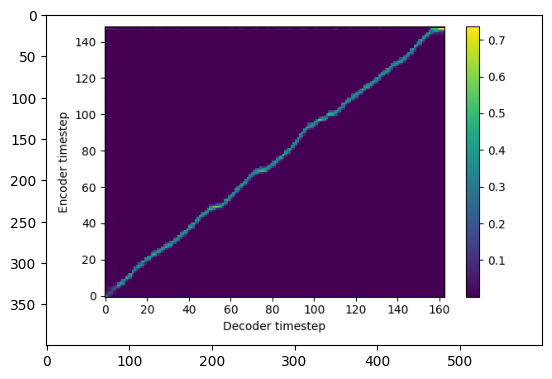

In [45]:
import matplotlib.pyplot as plt

item_idx = 0
for bidx, batch in enumerate(test_data_loader):
    print("Processing batch {} out of {}".format(bidx, len(test_data_loader)))
    model.t5_decoder.reset_cache(use_cache=True)
    batch_cuda ={}
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch_cuda[key] = batch[key].cuda()
        else:
            batch_cuda[key] = batch[key]
    import time
    st = time.time()
    predicted_audio, predicted_audio_lens, _, _, cross_attn_np = model.infer_batch(
        batch_cuda, 
        max_decoder_steps=500, 
        temperature=0.2, 
        topk=80, 
        use_cfg=True,
        cfg_scale=2.5,
        return_cross_attn_probs=True,
        apply_attention_prior=True,
    )
    print("generation time", time.time() - st)
    for idx in range(predicted_audio.size(0)):
        predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
        predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
        audio_path = os.path.join(out_dir, f"predicted_audio_{item_idx}.wav")
        sf.write(audio_path, predicted_audio_np, model.cfg.sample_rate)
        print(test_entries[item_idx]['text'])
        display(Audio(audio_path))
        item_idx += 1
        plt.imshow(cross_attn_np[idx])
        plt.show()

### Generation without Prior

Processing batch 0 out of 1
Decoding timestep 0
Decoding timestep 20
End detected for item 0 at timestep 21
All ends reached
generation time 0.9777224063873291
Hi


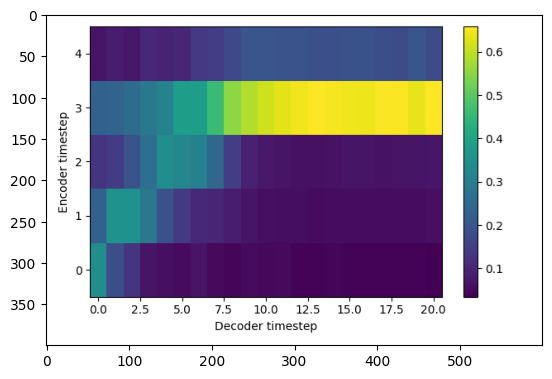

In [34]:
import matplotlib.pyplot as plt

item_idx = 0
for bidx, batch in enumerate(test_data_loader):
    print("Processing batch {} out of {}".format(bidx, len(test_data_loader)))
    model.t5_decoder.reset_cache(use_cache=True)
    batch_cuda ={}
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch_cuda[key] = batch[key].cuda()
        else:
            batch_cuda[key] = batch[key]
    import time
    st = time.time()
    predicted_audio, predicted_audio_lens, _, _, cross_attn_np = model.infer_batch(
        batch_cuda, 
        max_decoder_steps=500, 
        temperature=0.2, 
        topk=80, 
        use_cfg=False, 
        cfg_scale=2.5,
        return_cross_attn_probs=True,
        apply_attention_prior=False,
    )
    print("generation time", time.time() - st)
    for idx in range(predicted_audio.size(0)):
        predicted_audio_np = predicted_audio[idx].float().detach().cpu().numpy()
        predicted_audio_np = predicted_audio_np[:predicted_audio_lens[idx]]
        audio_path = os.path.join(out_dir, f"predicted_audio_{item_idx}.wav")
        sf.write(audio_path, predicted_audio_np, model.cfg.sample_rate)
        print(test_entries[item_idx]['text'])
        display(Audio(audio_path))
        item_idx += 1
        plt.imshow(cross_attn_np[idx])
        plt.show()